In [85]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk as vtk

In [86]:
%matplotlib widget

In [87]:
def gradients_to_dict(arr):
    keys = np.array(["dux/dx", "dux/dy", "dux/dz", "duy/dx", "duy/dy", "duy/dz", "duz/dx", "duz/dy", "duz/dz"])
    keys = keys.reshape((3,3))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

def gradients_to_dict2(arr):
    keys = np.array(["dU/dx", "dU/dy", "dU/dz"])
    keys = keys.reshape((3,1))[:,:arr.shape[1]].ravel()
    return dict(zip(keys, arr.T))

# Try to load case with pyvista.read

PyVista is smart enough to allow the load of an OpenFOAM case (.foam extension here)

In [88]:
# Import the OpenFOAM example case
case = pv.read('C:/Users/pret/Desktop/INSA HDF 5A/PLP 5A/OpenFOAM_example_case/case.foam')

In [89]:
case.keys()

['internalMesh']

In [90]:
mesh = case[0]

In [91]:
mesh

UnstructuredGrid (0x25dd8c735e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	10

* It looks like the number of arrays is doubled here, there is 2 times the `Data Arrays`.
* It looks like the case is loaded for `time=0`.

Here is for example below the U field where it's 0 everywhere expect at the inlet which is the intial condtion at `time=0`.

In [92]:
 mesh.plot(scalars='U',cpos='xy')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

A Jupyter widget could not be displayed because the widget state could not be found. This could happen if the kernel storing the widget is no longer available, or if the widget state was not saved in the notebook. You may be able to create the widget by running the appropriate cells.


# Load the case with `OpenFOAMReader`

In [93]:
reader = pv.OpenFOAMReader("C:/Users/pret/Desktop/INSA HDF 5A/PLP 5A/OpenFOAM_example_case/case.foam")
time = reader.time_values
print(time)

[0.0, 500.0, 1000.0]


In [94]:
reader.enable_all_patch_arrays()
reader.set_active_time_value(time[1]) # set time at whichever value we want to visualise
multi_block = reader.read()
print(multi_block.keys())
multi_block 

['internalMesh', 'Patches']


MultiBlock (0x25dd8c73e20)
  N Blocks:	2
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

Let's create two datasets: one that only contains the cell data and one that only contains the point data.

In [95]:
mesh_cell = multi_block[0]
mesh_point = mesh_cell.cell_data_to_point_data()
mesh_cell

UnstructuredGrid (0x25dd8ca08e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [96]:
mesh_point

UnstructuredGrid (0x25dd8c73520)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [97]:
mesh_bound_cell = multi_block[1]
mesh_bound_point = mesh_bound_cell.cell_data_to_point_data()
mesh_bound_cell

MultiBlock (0x25dd8ca0a60)
  N Blocks:	5
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

In [98]:
lower_wall_cell = mesh_bound_cell[3]
lower_wall_cell

PolyData (0x25dd8c73d00)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

In [99]:
mesh_bound_point

MultiBlock (0x25d16fdddc0)
  N Blocks:	5
  X Bounds:	-0.021, 0.290
  Y Bounds:	-0.025, 0.025
  Z Bounds:	-0.001, 0.001

In [100]:
lower_wall_point = mesh_bound_point[3]
lower_wall_point

PolyData (0x25d16fcd2e0)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	5

## Let's get the gradients at one of the patches

The following cells can be applied to any of the patches in `mesh_bound_cell` and `mesh_bound_point`. Here, we choose to apply it to the lower wall.

In [101]:
lower_wall_cell = lower_wall_cell.compute_derivative(scalars="U")
lower_wall_cell

PolyData (0x25d16fcd040)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	6

In [102]:
# deriv will contain the data from the gradient of U (9 components)
deriv_cell = lower_wall_cell.compute_derivative(scalars="U")

grad_cell = gradients_to_dict(deriv_cell["gradient"])

lower_wall_cell.cell_data["dux/dx"] = grad_cell["dux/dx"]
lower_wall_cell.cell_data["dux/dy"] = grad_cell["dux/dy"]
lower_wall_cell.cell_data["dux/dz"] = grad_cell["dux/dz"]
lower_wall_cell.cell_data["duy/dx"] = grad_cell["duy/dx"]
lower_wall_cell.cell_data["duy/dy"] = grad_cell["duy/dy"]
lower_wall_cell.cell_data["duy/dz"] = grad_cell["duy/dz"]
lower_wall_cell.cell_data["duz/dx"] = grad_cell["duz/dx"]
lower_wall_cell.cell_data["duz/dy"] = grad_cell["duz/dy"]
lower_wall_cell.cell_data["duz/dz"] = grad_cell["duz/dz"]

lower_wall_cell

PolyData (0x25d16fcd040)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	15

In [103]:
lower_wall_point = lower_wall_point.compute_derivative(scalars="U")
lower_wall_point

PolyData (0x25db9b26160)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	6

In [104]:
# deriv will contain the data from the gradient of U (9 components)
deriv_point = lower_wall_point.compute_derivative(scalars="U")

grad_point = gradients_to_dict(deriv_point["gradient"])

lower_wall_point.point_data["dux/dx"] = grad_point["dux/dx"]
lower_wall_point.point_data["dux/dy"] = grad_point["dux/dy"]
lower_wall_point.point_data["dux/dz"] = grad_point["dux/dz"]
lower_wall_point.point_data["duy/dx"] = grad_point["duy/dx"]
lower_wall_point.point_data["duy/dy"] = grad_point["duy/dy"]
lower_wall_point.point_data["duy/dz"] = grad_point["duy/dz"]
lower_wall_point.point_data["duz/dx"] = grad_point["duz/dx"]
lower_wall_point.point_data["duz/dy"] = grad_point["duz/dy"]
lower_wall_point.point_data["duz/dz"] = grad_point["duz/dz"]

lower_wall_point

PolyData (0x25db9b26160)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	15

In [105]:
lower_wall_cell= lower_wall_cell.compute_normals()
normals_cell = lower_wall_cell.active_normals
normals_cell.shape

(502, 3)

In [106]:
lower_wall_cell

PolyData (0x25d767d6d60)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	17

In [107]:
lower_wall_point= lower_wall_point.compute_normals()
normals_point = lower_wall_point.active_normals
normals_point.shape

(502, 3)

In [108]:
lower_wall_point.clear_cell_data()
lower_wall_point

PolyData (0x25d767d2700)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	16

## Show the mesh 

In [109]:
# Create a plotting object to display vtk meshes or numpy arrays
p = pv.Plotter()
# Show the mesh in wireframe style
p.add_mesh(mesh_cell, style="wireframe", color="w")
# View in the xy plane
p.view_xy()
# Show the axes
p.add_axes()
# Display the plotting window
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [110]:
# Create a plotting object to display vtk meshes or numpy arrays
p = pv.Plotter()
# Show the mesh in wireframe style
p.add_mesh(mesh_point, style="wireframe", color="w")
# View in the xy plane
p.view_xy()
# Show the axes
p.add_axes()
# Display the plotting window
p.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Plot the domain with a scalar field


In [111]:
# Plot the domain based on the cell data
p2 = pv.Plotter()
p2.add_mesh(mesh_cell, scalars='U')
p2.view_xy()
p2.add_axes()
p2.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [112]:
mesh_cell

UnstructuredGrid (0x25dd8ca08e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	6

In [113]:
# Plot the domain based on the point data
p2 = pv.Plotter()
p2.add_mesh(mesh_point, scalars='U')
p2.view_xy()
p2.add_axes()
p2.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [114]:
mesh_point

UnstructuredGrid (0x25dd8c73520)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	6

### Another one with the mesh surimposed

In [115]:
p3 = pv.Plotter()
p3.add_mesh(mesh_cell ,scalars='U', show_edges=True)
p3.view_xy()
p3.add_axes()
p3.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [116]:
p3 = pv.Plotter()
p3.add_mesh(mesh_point ,scalars='U', show_edges=True)
p3.view_xy()
p3.add_axes()
p3.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Plot the velocity field using glyphs

In [117]:
geom = pv.Arrow()
glyphs = mesh_cell.glyph(orient='U',scale='U-normed',factor=0.0005,geom=geom)
p4 = pv.Plotter()
p4.add_mesh(glyphs)
p4.view_xy()
p4.add_axes()
p4.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [118]:
geom = pv.Arrow()
glyphs = mesh_point.glyph(orient='U',scale='U-normed',factor=0.0005,geom=geom)
p4 = pv.Plotter()
p4.add_mesh(glyphs)
p4.view_xy()
p4.add_axes()
p4.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Plot over line example

In [119]:
# Create the 2 points defining the line
a = [0, 0, 0]
b = [0, mesh.bounds[3], 0]

# Create a Line object
line = pv.Line(a, b)

In [120]:
mesh.bounds

[-0.020600000396370888,
 0.28999999165534973,
 -0.02539999969303608,
 0.02539999969303608,
 -0.0005000000237487257,
 0.0005000000237487257]

Let's show the line in the computational domain

In [121]:
p5 = pv.Plotter()
p5.add_mesh(mesh_cell, style="wireframe", color='white')
# Show the line in red in the domain
p5.add_mesh(line, color="r", line_width=10)
p5.view_xy()
p5.add_axes()
p5.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's make a plot overline ...

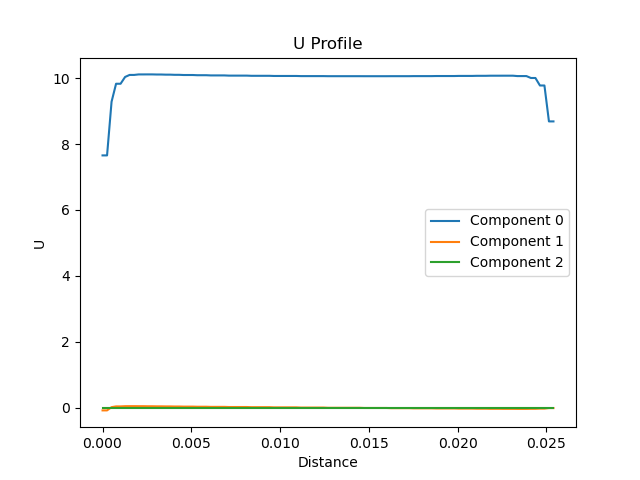

In [122]:
mesh_cell.plot_over_line(a, b, resolution=100, scalars='U')

In [123]:
p5 = pv.Plotter()
p5.add_mesh(mesh_point, style="wireframe", color='white')
# Show the line in red in the domain
p5.add_mesh(line, color="r", line_width=10)
p5.view_xy()
p5.add_axes()
p5.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

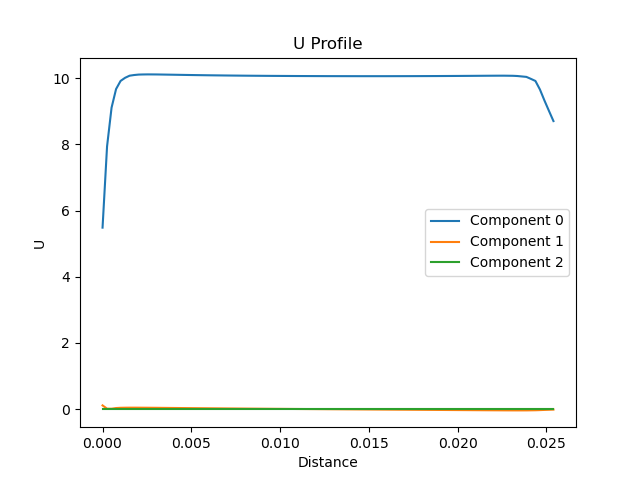

In [124]:
mesh_point.plot_over_line(a, b, resolution=100, scalars='U')

### How to access the vector components

In [125]:
mesh_cell.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : U-normed
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32  (12225, 3)           VECTORS
    epsilon                 float32  (12225,)
    k                       float32  (12225,)
    nut                     float32  (12225,)
    p                       float32  (12225,)
    U-normed                float32  (12225,)             SCALARS

In [126]:
ux = mesh_cell['U'][:,0]
uy = mesh_cell['U'][:,1]
uz = mesh_cell['U'][:,2]

mesh_cell.cell_data["ux"] = ux
mesh_cell.cell_data["uy"] = uy
mesh_cell.cell_data["uz"] = uz

mesh_cell

UnstructuredGrid (0x25dd8ca08e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

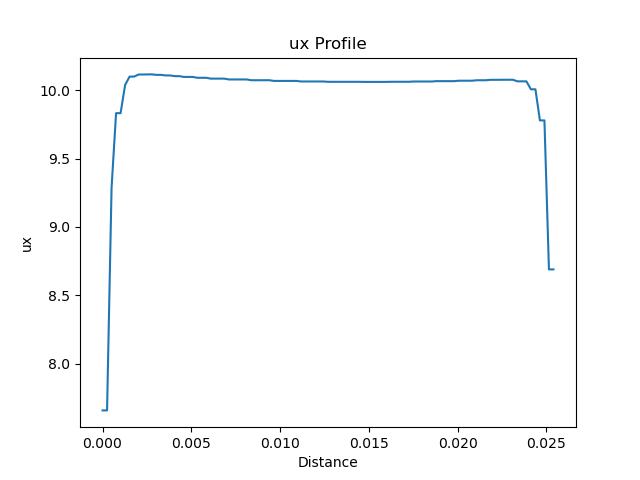

In [127]:
mesh_cell.plot_over_line(a, b, resolution=100, scalars='ux')

In [128]:
mesh_point.point_data

pyvista DataSetAttributes
Association     : POINT
Active Scalars  : U-normed
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32  (25012, 3)           VECTORS
    epsilon                 float32  (25012,)
    k                       float32  (25012,)
    nut                     float32  (25012,)
    p                       float32  (25012,)
    U-normed                float32  (25012,)             SCALARS

In [129]:
ux = mesh_point['U'][:,0]
uy = mesh_point['U'][:,1]
uz = mesh_point['U'][:,2]

mesh_point.point_data["ux"] = ux
mesh_point.point_data["uy"] = uy
mesh_point.point_data["uz"] = uz

mesh_point

UnstructuredGrid (0x25dd8c73520)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	9

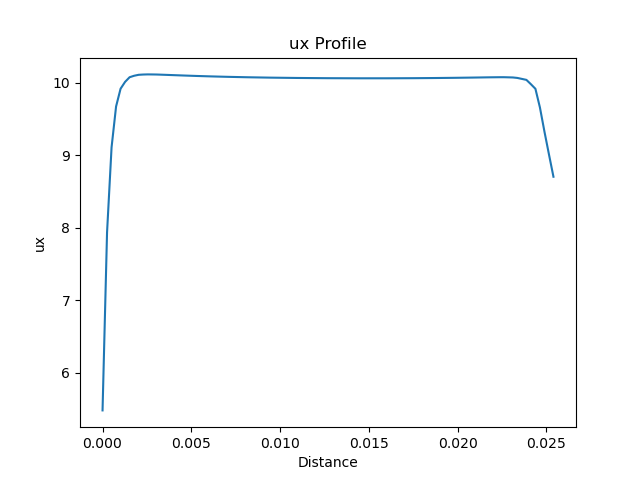

In [130]:
mesh_point.plot_over_line(a, b, resolution=100, scalars='ux')

## Plot a scalar over a circular arc

In [131]:
# Make two points at the bounds of the mesh and one at the center to
# construct a circular arc.
normal = [0, 0, 1]
polar = [0.02, 0, 0]
center = [0, 0, 0]
angle = 100.0

# Preview how this circular arc intersects this mesh
arc = pv.CircularArcFromNormal(center, 100, normal, polar, angle)

Let's see what's in the arc object.

In [132]:
arc

PolyData (0x25dfcef6ac0)
  N Cells:	1
  N Points:	101
  X Bounds:	-3.473e-03, 2.000e-02
  Y Bounds:	0.000e+00, 2.000e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	2

In [133]:
p6 = pv.Plotter()
p6.add_mesh(mesh_cell, style="wireframe", color="w")
p6.add_mesh(arc, color="r")
a = arc.points[0]
b = arc.points[-1]
p6.add_point_labels(
    [a, b], ["A", "B"], font_size=48, point_color="red", text_color="red"
)
p6.view_xy()
p6.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

I don't know how to add another plot on the same figure, it's perhaps only possible to plot one scalar or one vector at a time with this API.

In [134]:
#mesh_cell.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='ux')
#mesh_cell.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='uy')

So let's try another way and create the figure ourself (there may be better ways to do this by the way).

In [135]:
sampled = pv.DataSetFilters.sample_over_circular_arc_normal(mesh_cell,center,100,normal,polar,angle)

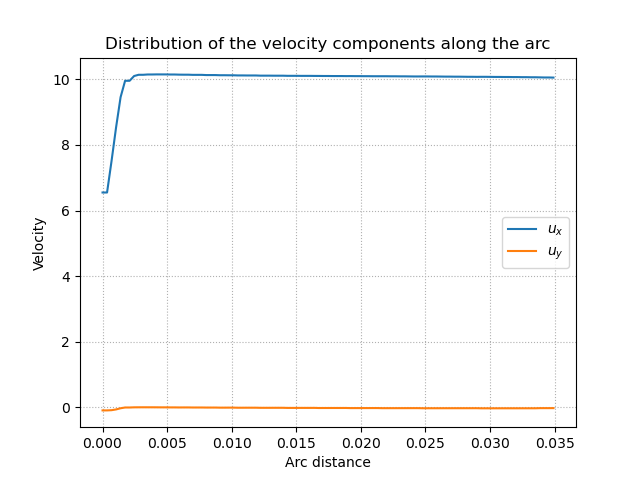

In [136]:
plt.figure()
plt.plot(sampled['Distance'],sampled['ux'],label='$u_x$')
plt.plot(sampled['Distance'],sampled['uy'],label='$u_y$')
plt.xlabel('Arc distance')
plt.ylabel('Velocity')
plt.title('Distribution of the velocity components along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

In [137]:
sampled = pv.DataSetFilters.sample_over_circular_arc_normal(mesh_point,center,100,normal,polar,angle)

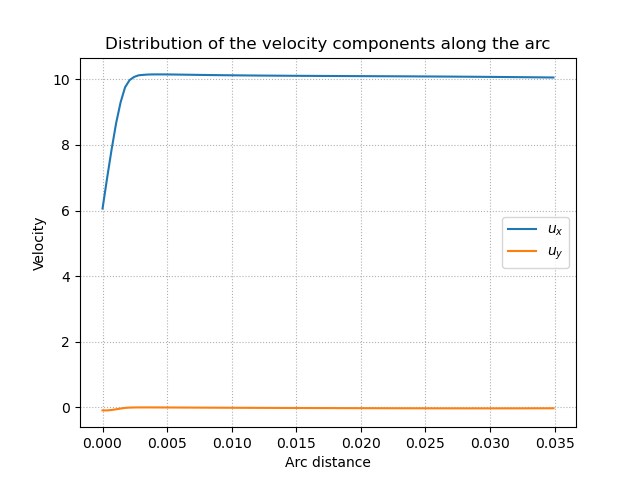

In [138]:
plt.figure()
plt.plot(sampled['Distance'],sampled['ux'],label='$u_x$')
plt.plot(sampled['Distance'],sampled['uy'],label='$u_y$')
plt.xlabel('Arc distance')
plt.ylabel('Velocity')
plt.title('Distribution of the velocity components along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()

## Fields

In [139]:
### k field (cell data)

p7 = pv.Plotter()
p7.add_mesh(mesh_cell,scalars='k')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [140]:
### k field (point data)

p7 = pv.Plotter()
p7.add_mesh(mesh_point,scalars='k')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [141]:
### epsilon field (cell data)

p7 = pv.Plotter()
p7.add_mesh(mesh_cell,scalars='epsilon')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [142]:
### epsilon field (point data)

p7 = pv.Plotter()
p7.add_mesh(mesh_point,scalars='epsilon')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [143]:
### nut field (cell data)

p7 = pv.Plotter()
p7.add_mesh(mesh_cell,scalars='nut')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [144]:
### nut field (point data)

p7 = pv.Plotter()
p7.add_mesh(mesh_point,scalars='nut')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [145]:
### pressure field (cell data)

p7 = pv.Plotter()
p7.add_mesh(mesh_cell,scalars='p')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [146]:
### pressure field (point data)

p7 = pv.Plotter()
p7.add_mesh(mesh_point,scalars='p')
p7.view_xy()
p7.add_axes()
p7.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Let's plot the streamlines

In [147]:
X_center = (mesh_cell.bounds[0]+mesh_cell.bounds[1])/2
Y_center = (mesh_cell.bounds[2]+mesh_cell.bounds[3])/2
Z_center = (mesh_cell.bounds[4]+mesh_cell.bounds[5])/2
centers = [X_center, Y_center, Z_center] 

In [148]:
face = mesh_point.slice(normal='x') # "normal" should be set as the direction of the flow
slices = mesh_point.slice_along_axis(n=8, axis="x") # axis is the axis of the flow
faces = slices.combine() # converts Multiblock into UnstructuredGrid 

str1 = mesh_point.streamlines_from_source(faces, vectors='U') # streamlines using multiple surfaces
str2 = mesh_point.streamlines_from_source(face, vectors='U') # streamlines using a singular surface
# both require a dataset for the surface

str3 = mesh_point.streamlines( 
n_points=100,
vectors='U',
pointa=(mesh_cell.bounds[0], mesh_cell.bounds[2], centers[2]),
pointb=(mesh_cell.bounds[0], mesh_cell.bounds[3], centers[2])
)  # Streamlines using a line

We'll compare between the streamlines obtained from one singular surface (str1) and those obtained using a higher number of equidistant parallel surfaces (str2). 
The most accurate of the two cases is the one that resembles what we obtain with ParaView the most.

In [149]:
# Streamlines obtained from a higher number of equidistant parallel surfaces
p8 = pv.Plotter()
p8.add_mesh(mesh_point, color="w")
p8.add_mesh(str1.tube(radius=0.0004))
# View in the xy plane
p8.view_xy()
# Show the axes
p8.add_axes()
# Display the plotting window
p8.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [150]:
# Streamlines obtained from one singular surface
p9 = pv.Plotter()
p9.add_mesh(mesh_point, color="w")
p9.add_mesh(str2.tube(radius=0.0004))
# View in the xy plane
p9.view_xy()
# Show the axes
p9.add_axes()
# Display the plotting window
p9.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

It seems this only works with `mesh_point` and not with `mesh_cell`

## Let's determine the friction velocity

In [151]:
# deriv will contain the data from the gradient of U (9 components)
deriv_cell = mesh_cell.compute_derivative(scalars="U")
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2_cell = mesh_cell.compute_derivative(scalars="U-normed")

grad_cell = gradients_to_dict(deriv_cell["gradient"])
grad2_cell = gradients_to_dict2(deriv2_cell["gradient"])

mesh_cell.cell_data["dU/dx"] = grad2_cell["dU/dx"]
mesh_cell.cell_data["dU/dy"] = grad2_cell["dU/dy"]
mesh_cell.cell_data["dU/dz"] = grad2_cell["dU/dz"]
mesh_cell.cell_data["dux/dx"] = grad_cell["dux/dx"]
mesh_cell.cell_data["dux/dy"] = grad_cell["dux/dy"]
mesh_cell.cell_data["dux/dz"] = grad_cell["dux/dz"]
mesh_cell.cell_data["duy/dx"] = grad_cell["duy/dx"]
mesh_cell.cell_data["duy/dy"] = grad_cell["duy/dy"]
mesh_cell.cell_data["duy/dz"] = grad_cell["duy/dz"]
mesh_cell.cell_data["duz/dx"] = grad_cell["duz/dx"]
mesh_cell.cell_data["duz/dy"] = grad_cell["duz/dy"]
mesh_cell.cell_data["duz/dz"] = grad_cell["duz/dz"]

mesh_cell

UnstructuredGrid (0x25dd8ca08e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	21

In [152]:
# deriv will contain the data from the gradient of U (9 components)
deriv_point = mesh_point.compute_derivative(scalars="U")
# deriv2 will contain the data from the gradient of U-normed (3 components)
deriv2_point = mesh_point.compute_derivative(scalars="U-normed")

grad_point = gradients_to_dict(deriv_point["gradient"])
grad2_point = gradients_to_dict2(deriv2_point["gradient"])

mesh_point.point_data["dU/dx"] = grad2_point["dU/dx"]
mesh_point.point_data["dU/dy"] = grad2_point["dU/dy"]
mesh_point.point_data["dU/dz"] = grad2_point["dU/dz"]
mesh_point.point_data["dux/dx"] = grad_point["dux/dx"]
mesh_point.point_data["dux/dy"] = grad_point["dux/dy"]
mesh_point.point_data["dux/dz"] = grad_point["dux/dz"]
mesh_point.point_data["duy/dx"] = grad_point["duy/dx"]
mesh_point.point_data["duy/dy"] = grad_point["duy/dy"]
mesh_point.point_data["duy/dz"] = grad_point["duy/dz"]
mesh_point.point_data["duz/dx"] = grad_point["duz/dx"]
mesh_point.point_data["duz/dy"] = grad_point["duz/dy"]
mesh_point.point_data["duz/dz"] = grad_point["duz/dz"]

mesh_point

UnstructuredGrid (0x25dd8c73520)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	21

## Let's plot gradient components 

In [153]:
### plotting of dux/dx (cell data)

p10 = pv.Plotter()
p10.add_mesh(mesh_cell,scalars="dux/dx")
p10.view_xy()
p10.add_axes()
p10.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [154]:
### plotting of dux/dx (point data)

p10 = pv.Plotter()
p10.add_mesh(mesh_point,scalars="dux/dx")
p10.view_xy()
p10.add_axes()
p10.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [155]:
### multiplot, plotting of du/dx and dv/dx (cell data)

plotter = pv.Plotter(shape=(1, 2))

plotter.subplot(0, 0)
plotter.add_text("dux/dx", font_size=20)
plotter.add_mesh(mesh_cell,scalars="dux/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("duy/dx", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dx")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [156]:
### multiplot, plotting of du/dx and dv/dx (point data)

plotter = pv.Plotter(shape=(1, 2))

plotter.subplot(0, 0)
plotter.add_text("dux/dx", font_size=20)
plotter.add_mesh(mesh_point,scalars="dux/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("duy/dx", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dx")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [157]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx", font_size=20)
plotter.add_mesh(mesh_cell,scalars="dux/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [158]:
### multiplot, plotting all the gradient components 
### {du/dx, du/dy, du/dz, dv/dx, dv/dy, dv/dz, dw/dx, dw/dy, dw/dz}

plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx", font_size=20)
plotter.add_mesh(mesh_point,scalars="dux/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dx")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dy")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Vectors normalization compared to the maximal component 

In [159]:
duxdx_norm=(mesh_cell["dux/dx"]-min(mesh_cell["dux/dx"]))/(max(mesh_cell["dux/dx"])-min(mesh_cell["dux/dx"]))
duydx_norm=(mesh_cell["duy/dx"]-min(mesh_cell["duy/dx"]))/(max(mesh_cell["duy/dx"])-min(mesh_cell["duy/dx"]))
duzdx_norm=(mesh_cell["duz/dx"]-min(mesh_cell["duz/dx"]))/(max(mesh_cell["duz/dx"])-min(mesh_cell["duz/dx"]))
duxdy_norm=(mesh_cell["dux/dy"]-min(mesh_cell["dux/dy"]))/(max(mesh_cell["dux/dy"])-min(mesh_cell["dux/dy"]))
duydy_norm=(mesh_cell["duy/dy"]-min(mesh_cell["duy/dy"]))/(max(mesh_cell["duy/dy"])-min(mesh_cell["duy/dy"]))
duzdy_norm=(mesh_cell["duz/dy"]-min(mesh_cell["duz/dy"]))/(max(mesh_cell["duz/dy"])-min(mesh_cell["duz/dy"]))
#duxdz_norm=(mesh_cell["dux/dz"]-min(mesh_cell["dux/dz"]))/(max(mesh_cell["dux/dz"])-min(mesh_cell["dux/dz"]))
#duydz_norm=(mesh_cell["duy/dz"]-min(mesh_cell["duy/dz"]))/(max(mesh_cell["duy/dz"])-min(mesh_cell["duy/dz"]))
#duzdz_norm=(mesh_cell["duz/dz"]-min(mesh_cell["duz/dz"]))/(max(mesh_cell["duz/dz"])-min(mesh_cell["duz/dz"]))

We have to add these data to the `mesh_cell` available fields if we want to plot them. Otherwise, their names would be "Data" (see last attempt with "a").

In [160]:
mesh_cell.cell_data["dux/dx n"] = duxdx_norm
mesh_cell.cell_data["duy/dx n"] = duydx_norm
mesh_cell.cell_data["duz/dx n"] = duzdx_norm
mesh_cell.cell_data["dux/dy n"] = duxdy_norm
mesh_cell.cell_data["duy/dy n"] = duydy_norm
mesh_cell.cell_data["duz/dy n"] = duzdy_norm
#mesh_cell.cell_data["dux/dz n"] = duxdz_norm
#mesh_cell.cell_data["duy/dz n"] = duydz_norm
#mesh_cell.cell_data["duz/dz n"] = duzdz_norm

Be careful: 0 division in the case of z gradient components 

And the script is pretty big s*** for the moment: we have to impove that with "for" loop ect...

In [161]:
mesh_cell

UnstructuredGrid (0x25dd8ca08e0)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	27

In [162]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(mesh_cell,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(mesh_cell.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

In [163]:
duxdx_norm=(mesh_point["dux/dx"]-min(mesh_point["dux/dx"]))/(max(mesh_point["dux/dx"])-min(mesh_point["dux/dx"]))
duydx_norm=(mesh_point["duy/dx"]-min(mesh_point["duy/dx"]))/(max(mesh_point["duy/dx"])-min(mesh_point["duy/dx"]))
duzdx_norm=(mesh_point["duz/dx"]-min(mesh_point["duz/dx"]))/(max(mesh_point["duz/dx"])-min(mesh_point["duz/dx"]))
duxdy_norm=(mesh_point["dux/dy"]-min(mesh_point["dux/dy"]))/(max(mesh_point["dux/dy"])-min(mesh_point["dux/dy"]))
duydy_norm=(mesh_point["duy/dy"]-min(mesh_point["duy/dy"]))/(max(mesh_point["duy/dy"])-min(mesh_point["duy/dy"]))
duzdy_norm=(mesh_point["duz/dy"]-min(mesh_point["duz/dy"]))/(max(mesh_point["duz/dy"])-min(mesh_point["duz/dy"]))
#duxdz_norm=(mesh_point["dux/dz"]-min(mesh_point["dux/dz"]))/(max(mesh_point["dux/dz"])-min(mesh_point["dux/dz"]))
#duydz_norm=(mesh_point["duy/dz"]-min(mesh_point["duy/dz"]))/(max(mesh_point["duy/dz"])-min(mesh_point["duy/dz"]))
#duzdz_norm=(mesh_point["duz/dz"]-min(mesh_point["duz/dz"]))/(max(mesh_point["duz/dz"])-min(mesh_point["duz/dz"]))

In [164]:
mesh_point.point_data["dux/dx n"] = duxdx_norm
mesh_point.point_data["duy/dx n"] = duydx_norm
mesh_point.point_data["duz/dx n"] = duzdx_norm
mesh_point.point_data["dux/dy n"] = duxdy_norm
mesh_point.point_data["duy/dy n"] = duydy_norm
mesh_point.point_data["duz/dy n"] = duzdy_norm
#mesh_point.point_data["dux/dz n"] = duxdz_norm
#mesh_point.point_data["duy/dz n"] = duydz_norm
#mesh_point.point_data["duz/dz n"] = duzdz_norm

In [165]:
mesh_point

UnstructuredGrid (0x25dd8c73520)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	27

In [166]:
#plot
plotter = pv.Plotter(shape=(3, 3))

plotter.subplot(0, 0)
plotter.add_text("dux/dx n", font_size=20)
plotter.add_mesh(mesh_point,scalars='dux/dx n')
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 1)
plotter.add_text("dux/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(0, 2)
plotter.add_text("dux/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="dux/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 0)
plotter.add_text("duy/dx n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 1)
plotter.add_text("duy/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(1, 2)
plotter.add_text("duy/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duy/dz")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 0)
plotter.add_text("duz/dx n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dx n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 1)
plotter.add_text("duz/dy n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dy n")
plotter.view_xy()
plotter.add_axes()

plotter.subplot(2, 2)
plotter.add_text("duz/dz n", font_size=20)
plotter.add_mesh(mesh_point.copy(),scalars="duz/dz")
plotter.view_xy()
plotter.add_axes()

plotter.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Wall shear stress

This part requires an updated version of PyVista.

In the Anaconda prompt, please type "conda install git" and execute.

Then, in the cell just below, copy paste and execute this instruction: 

pip install git+https://github.com/pyvista/pyvista.git@refs/pull/1896/head

(Be aware of having the administrator rights in both cases)

In [83]:
# copy paste last instruction here (to do the installation only one time)

In [169]:
pdt_scal=np.dot(lower_wall_point.point_data["dux/dy"],lower_wall_point.point_data["Normals"])
lower_wall_point.point_data["dux/dy"].shape
pdt_scal

pyvista_ndarray([-19793.492 ,  -7672.8223,      0.    ], dtype=float32)

In [170]:
visc=18.5e-6
wss=visc*pdt_scal
lower_wall_point.add_field_data(wss, 'wss')
lower_wall_point

PolyData (0x25d767d2700)
  N Cells:	250
  N Points:	502
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 0.000e+00
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	17